# Adversarial Search: Playing "Mean" Connect 4 - Troy McNitt


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

Initial State - We start with an empty board. 

Actions - We can place a piece in every column that is not full when it is our turn. Since its mean connect four, we also can take an opponents piece from the bottom row of a column and move it to another column that is not full.

Test for terminal state - We need to check for 4 in a row horizontally, vertically, or diagonally. The game is a draw if every column is full or we have made 100 moves.

How big is the state space? Give an estimate and explain it.

The upper bound of the state space will be all the possible combinations of pieces on the board. For a 7x6 board that would be 42 spaces. Each space can take three possible values (red, yellow, no piece). This means the upper bound on state space is 3^42. That's a very big number! Of course, many of these states are not possible since they include several 4 in a rows that would have ended the game.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

Min max, without alpha beta pruning, will need to explore all possible paths. This means we can compute the size of the upper bound of the search by the formula O(b^d) where b is the branching factor and d is the depth. For noral connect four, the branching factor is 7 (each column). However as a worse case in mean connect four, the player could move a piece from each column (7) to any other column (6). That equals another 42 possible moves. This means our worst case branching factor is 49. For depth, in normal connect four it would just be 7*6 since the board would fill up. However since the mean moves allow moves that do not place any pieces, it could be up 100 moves before a draw is deeclared.  That means the game tree would be size 49^100.. This means we will never be able to solve the game with minmax search.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

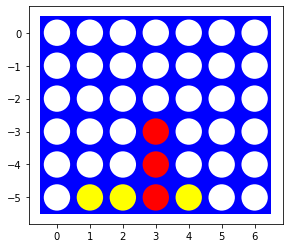

In [1]:
import matplotlib.pyplot as plt
import numpy as np 

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $results(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

There is a smart way to represent a connect four game by John Tromp. His website can be found [here](https://tromp.github.io). Professor Herzberg is a professor at the Technische Hochschule Mittelhessen and wrote a great explanation of Tromp's code and published it on [github](https://github.com/denkspuren/BitboardC4/blob/master/BitboardDesign.md). 

It is based on storing a players move as a bitboard, which is nothing more than an unsigned 64 bit integer. The assignment of what position corresponds to what bit is shown below. With these positions, you can use bit operations to determine if a player has won. This mapping also make it easy to see if a column can take any more pieces and is a valid next move. He also writes about keeping track of the heights for each column, so that the state transition is fast. I took the psuedocode and implemented it in python below.

~~~

 6 13 20 27 34 41 48   55 62     Additional row
+---------------------+ 
| 5 12 19 26 33 40 47 | 54 61     top row
| 4 11 18 25 32 39 46 | 53 60
| 3 10 17 24 31 38 45 | 52 59
| 2  9 16 23 30 37 44 | 51 58
| 1  8 15 22 29 36 43 | 50 57
| 0  7 14 21 28 35 42 | 49 56 63  bottom row
+---------------------+
~~~

Since this format is very different than how it is stored above, I created functions to convert to and from the bitboard format. Using numba JIT compilation, I'm able to achieve a 5x speedup over the python native implementation. I also added the mean twist to all the different functions to make it work with the rules of the game.

In [2]:
from numba.experimental import jitclass
from numba import njit
from numba import uint64, boolean

spec = [
    ('HEIGHT', uint64),              
    ('WIDTH', uint64),       
    ('H1', uint64),      
    ('H2', uint64),  
    ('SIZE1', uint64),         
    ('COL1', uint64),         
    ('ALL1', uint64),         
    ('BOTTOM', uint64),         
    ('TOP', uint64),         
    ('FULL', uint64), 
    ('heights', uint64[:]),  
    ('boards', uint64[:]),     
    ('player_one_mean', boolean),
    ('player_two_mean', boolean)    
]

@jitclass(spec)
class Bitboard():

    def setup_params(self, width, height):
        self.HEIGHT = np.uint64(height)
        self.WIDTH = np.uint64(width)
        self.H1 = np.uint64(self.HEIGHT+1)
        self.H2 = np.uint64(self.HEIGHT+2)
        self.SIZE1 = np.uint64(self.H1*self.WIDTH)
        self.COL1 = np.uint64((np.uint64(1)<<self.H1)-np.uint64(1))
        self.ALL1 = np.uint64((np.uint64(1)<<self.SIZE1)-np.uint64(1))
        self.BOTTOM = np.uint64(self.ALL1 / self.COL1) 
        self.TOP  = (self.BOTTOM << self.HEIGHT)
        self.FULL = (self.BOTTOM << (self.HEIGHT-np.uint64(1)))



    def __init__(self, width, height, boards=None, heights=None, player_one_mean=True, player_two_mean=True):
        self.setup_params(width, height)

        self.player_one_mean = player_one_mean
        self.player_two_mean = player_two_mean
        
        if heights is not None:
            self.heights = heights.copy()
        else:
            self.heights = np.zeros(shape=self.WIDTH, dtype=np.uint64)
            self.make_bitboard_heights()

        if boards is not None:
            self.boards = boards.copy()
        else:
            self.boards = np.array([np.uint64(0), np.uint64(0)])

    def copy(self):
        return Bitboard(self.WIDTH, self.HEIGHT, self.boards, self.heights, self.player_one_mean, self.player_two_mean)

    def make_bitboard_heights(self):
        for i in range(self.WIDTH):
            self.heights[i] = i*self.H1

    def shift_pieces_down(self, index, col):
        old_col_starting_height = col*self.H1

        # Get all the values for this column
        column = self.COL1 << old_col_starting_height
        curr_column_values = self.boards[index] & column

        # Clear them all
        self.boards[index] ^= curr_column_values

        # Clear out the one we pushed off the board
        curr_column_values &= ~(np.uint64(1) << old_col_starting_height)

        # Set them to the shifted version
        self.boards[index] ^= curr_column_values >> np.uint64(1)


    def make_normal_bitboard_move(self, counter, col):
        # Using the column, shift it to the right position
        update = np.uint64(1) << self.heights[col]

        # Keep track of the height for next time
        self.heights[col] += 1

        # Set this bit on the board
        self.boards[counter & 1] ^= update


    def make_mean_bitboard_move(self, counter, old_col, new_col):
        # Shift both boards down in that column
        self.shift_pieces_down(0, old_col)
        self.shift_pieces_down(1, old_col)
        self.heights[old_col] -= 1

        # Place the piece in the old column
        # Note we shift counter since its an opponent piece
        self.make_normal_bitboard_move(int(not (counter & 1)), new_col)

    def make_move(self, counter, move):
        if(move < 10):
            self.make_normal_bitboard_move(counter & 1, move-1)
        else:
            from_col = move // 10
            to_col = move % 10
            self.make_mean_bitboard_move(counter & 1, from_col-1, to_col-1)


    def get_actions(self, counter):
        moves = []

        for col in range(self.WIDTH):
            if self.isplayable_normal(col):
                moves.append(col+1)
        
        
        if (counter & 1) == 0:
            if not self.player_one_mean: 
                return moves
        else:
            if not self.player_two_mean:
                return moves
        
        for start in range(self.WIDTH):
            for end in range(self.WIDTH):
                if start == end:
                    continue
            
                if self.isplayable_mean(counter, start, end):
                    num = ((start+1)*10) + (end+1)
                    moves.append(num)

        return moves

    def is_full(self):
        return self.FULL == (self.FULL & (self.boards[0] | self.boards[1]))

    def is_bitboard_win(self, index):
        board = self.boards[index]

        # diagonal \
        diag1 = board & (board >> self.HEIGHT)

        # diagonal /
        diag2 = board & (board >> self.H2)

        # horizontal
        hori = board & (board >> self.H1)

        # vertical
        vert = board & (board >> np.uint64(1))

        return ((diag1 & (diag1 >> 2*self.HEIGHT)) |
            (hori & (hori >> 2*self.H1)) |
            (diag2 & (diag2 >> 2*self.H2)) |
            (vert & (vert >> 2))) != 0

    def is_bitboard_3_in_a_row(self, index):
        board = self.boards[index]

        # diagonal \
        diag1 = board & (board >> (self.HEIGHT))

        # diagonal /
        diag2 = board & (board >> (self.H2))

        # horizontal
        hori = board & (board >> (self.H1))

        # vertical
        vert = board & (board >> np.uint64(1))

        return ((diag1 & (diag1 >> self.HEIGHT)) |
            (hori & (hori >> self.H1)) |
            (diag2 & (diag2 >> self.H2)) |
            (vert & (vert >> 1))) != 0
        #return (vert & (vert >> 2))
        
    def isplayable_normal(self, column):
        return (self.TOP & (np.uint64(1) << self.heights[column])) == 0

    def isplayable_mean(self, counter, from_col, end_col):
        other_board = int(not (counter & 1))

        pos = np.uint64(1) << (np.uint64(from_col)*self.H1)
        if (self.boards[other_board] & pos) == 0:
            return False
        
        return self.isplayable_normal(end_col)

    def get_transposition_key(self, move_num):
        return self.boards[move_num & 1] + self.boards[0] + self.boards[1] + self.BOTTOM
    
    def bitboards_to_class_board(self):
        red_board = self.boards[0]
        yellow_board = self.boards[1]

        classboard = np.zeros(shape=(self.HEIGHT, self.WIDTH), dtype=np.int32)

        for row in range(self.HEIGHT):
            for col in range(7):
                bit = np.uint64(1) << (np.uint8(self.H1*col)+np.uint64(row))

                # If there is piece there, update class board
                if (red_board & bit) != 0:
                    classboard[int(self.HEIGHT)-row-1][col] = 1

                # Same but with other board
                if (yellow_board & bit) != 0:
                    classboard[int(self.HEIGHT)-row-1][col] = -1

        return classboard


def class_board_to_bitboards(classboard):
    height = classboard.shape[0]
    width = classboard.shape[1]

    board = Bitboard(height, width)

    for row in range(int(height)-1, -1, -1):
        for col in range(width):
            cpiece = classboard[row][col]
            if cpiece == 1:
                board.make_normal_bitboard_move(0, col)
            if cpiece == -1:
                board.make_normal_bitboard_move(1, col)

    return board


The above code supports the regular and mean moves at varying board sizes.

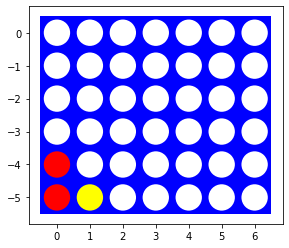

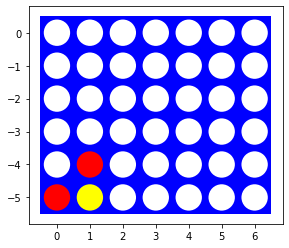

In [3]:
board = Bitboard(7, 6)

board.make_move(0, 1)
board.make_move(1, 2)
board.make_move(0, 1)

visualize(board.bitboards_to_class_board())

board.make_move(1, 12)

visualize(board.bitboards_to_class_board())

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action.

In [4]:
@njit()
def random_agent(board, counter):
    moves = np.array(board.get_actions(counter))

    if len(moves) == 0:
        return None
        
    move = np.random.choice(moves, size=1)[0]
    return move

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how ranom agents can play against each other.

How often does each player win? Is the result expected?

In [5]:
def play(red, yellow, N = 100, pomm=True, ptwmm=True):
    results = {'red': 0, 'yellow': 0, 'd': 0}
    
    funcs = [red, yellow]

    for _ in range(N):
        board = Bitboard(7, 6, player_one_mean=pomm, player_two_mean=ptwmm)

        for move_num in range(100):
            func = funcs[move_num & 1]

            move = func(board, move_num)

            if move is None:
                results['d'] += 1
                break

            board.make_move(int(move_num), int(move))
            
            if board.is_bitboard_win(0):
                results['red'] += 1
                break

            if board.is_bitboard_win(1):
                results['yellow'] += 1
                break
        
        if move_num == 99:
            results['d'] += 1
    
    return results

In [6]:
play(random_agent, random_agent, 1_000)

{'red': 772, 'yellow': 228, 'd': 0}

Looking at the above results, it looks like player one has a huge advantage over player two. To see how this compares to just regular connect four without the mean moves, I ran that as well below.

In [7]:
play(random_agent, random_agent, 1_000, False, False)

{'red': 537, 'yellow': 462, 'd': 1}

So yes, player one seems to have an even bigger advantage than player two in mean connect four.

In [8]:
play(random_agent, random_agent, 1_000, False, True)

{'red': 984, 'yellow': 16, 'd': 0}

Not allowing player one to use mean moves but allowing player two to use them made player one almost never lose. This shows that mean moves should almost never be used.

## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting from a given board and specifying the player.

You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).


__Note:__ The game tree for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$).

To make my minmax implementation more efficient, I realized that the minimum move for one player is the maximum move for another. This way, we can implement only one function and just invert the value. This is just a semantic change, and is the same algorithm.

To make it even more efficient, I use whats called a transposition table. This is basically a cache so we do not have to recompute a board more than once. John Tromp demonstrated that with his bitboard idea, you could store the board as a 56 bit key. To keep things efficient, we keep the table limited to 64MB and use LIFO removal policy.

In [9]:
TRANSPOSITION_SIZE = 8388593 #64MB transposition table

def alpha_beta_search(board, counter=0, depth=20):
    """start the search."""
    transposition_keys = np.zeros(shape=(TRANSPOSITION_SIZE+1),dtype=np.uint64)
    transposition_vals = np.zeros(shape=(TRANSPOSITION_SIZE+1),dtype=np.int8)

    value, move = min_max_search(board, counter, -1, 1, depth, transposition_keys, transposition_vals)

    return { "value": value, "move": move }

@njit()
def min_max_search(board, move_num, alpha, beta, depth, transposition_keys, transposition_vals):
    # Check for give up state
    if board.is_full() or depth == 0:
        return 0, None

    # Check if we have already computed this board
    key = board.get_transposition_key(move_num)
    index = key % TRANSPOSITION_SIZE
    val = transposition_vals[index]

    if transposition_keys[index] == key:
        # We found lowerbound, tighten our search
        alpha = max(alpha, val)

    if alpha >= beta:
        return alpha, None
    
    # Check if any immediate move could lead to terminal state
    for a in board.get_actions(move_num):
        a_board = board.copy()
        a_board.make_move(move_num, a)

        if a_board.is_bitboard_win(move_num & 1):
            return 1, a

        if a_board.is_bitboard_win(int(not(move_num & 1))):
            return -1, a
    
    #Depen the search
    move = None
    
    for a in board.get_actions(move_num):
        a_board = board.copy()
        a_board.make_move(move_num, a)

        # By calling the same method swapping beta and alpha represents the min move
        # This means we only have to write one funciton! Cool!
        score, _ = min_max_search(a_board, move_num + 1, -beta,-alpha, depth-1, transposition_keys, transposition_vals)

        # And we can just invert the score at the end
        # This is because the best move for them is the worst move for us
        score = -score

        # Check if we have escaped window
        if score >= beta:
            # We're done, prune the rest
            return score, a

        # Update alpha always to shrink upperbound
        if score > alpha: 
            alpha = score
            move = a
    
    # Update the lower bound for this state
    # We could also update exact and upper bound
    # But seems to be less used
    key = board.get_transposition_key(move_num)
    index = key % TRANSPOSITION_SIZE
    transposition_keys[index] = key
    transposition_vals[index] = alpha

    return alpha, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

Note that I increment all the moves by one. So move 1 equals placing a piece in the column "0". This way, I can represent mean moves as number greater than 10. For example, move 14 would mean moving a piece from column oen to column four.

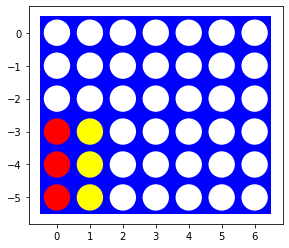

{'value': 1, 'move': 1}

In [11]:
board = Bitboard(7, 6)

board.make_move(0, 1)
board.make_move(1, 2)
board.make_move(0, 1)
board.make_move(1, 2)
board.make_move(0, 1)
board.make_move(1, 2)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search(board)

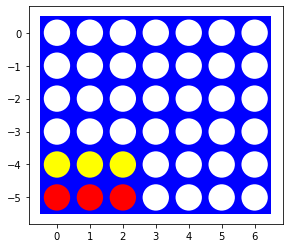

{'value': 1, 'move': 4}

In [12]:
board = Bitboard(7, 6)

board.make_move(0, 1)
board.make_move(1, 1)
board.make_move(0, 2)
board.make_move(1, 2)
board.make_move(0, 3)
board.make_move(1, 3)


classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search(board)

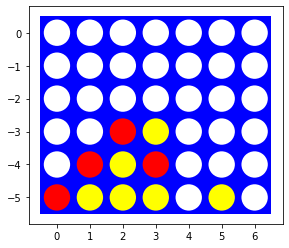

{'value': 1, 'move': 4}

In [13]:
board = Bitboard(7, 6)

board.make_move(0, 1)
board.make_move(1, 2)
board.make_move(0, 2)
board.make_move(1, 3)
board.make_move(1, 3)
board.make_move(1, 4)
board.make_move(0, 3)
board.make_move(1, 6)
board.make_move(0, 4)
board.make_move(1, 4)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search(board)

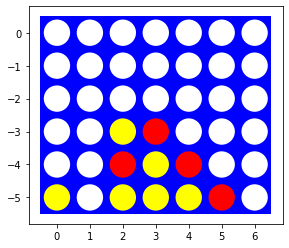

{'value': 1, 'move': 3}

In [14]:
board = Bitboard(7,6)

board.make_move(0, 7-1)
board.make_move(1, 7-2)
board.make_move(0, 7-2)
board.make_move(1, 7-3)
board.make_move(1, 7-3)
board.make_move(1, 7-4)
board.make_move(0, 7-3)
board.make_move(1, 7-6)
board.make_move(0, 7-4)
board.make_move(1, 7-4)


classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search(board)

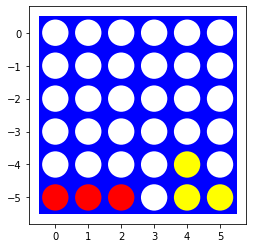

{'value': 1, 'move': 4}

In [12]:
board = Bitboard(6,6, player_one_mean=False, player_two_mean=False)

board.make_move(0, 1)
board.make_move(1, 6)
board.make_move(0, 2)
board.make_move(1, 5)
board.make_move(0, 3)
board.make_move(1, 5)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search(board, depth=22)

From the above, we can see it can recognize easy winning moves.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

Unfortunately even on a 4x4 board, there are simply too many mean moves to simulate in a reasonable amount of time. However, I can simulate if player one can not use mean moves but player two can. I really wanted to be able to simulate the mean moves and went as far as to rewrite the code in C++ and run it on the lyle genuse servers, but even that was no match for the mean move branching factor.

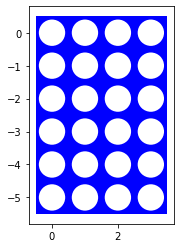

{'value': -1, 'move': None}

In [11]:
board = Bitboard(4,6, player_one_mean=False, player_two_mean=True)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search(board)

In 30 seconds we can compute the result of the 4x6 board from the starting position. Regardless of our move, we will lose as the first player. This is becuase we aren't using any mean moves.

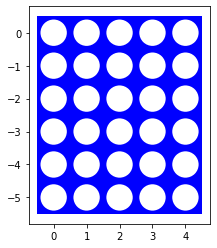

{'value': -1, 'move': 1}

In [36]:
board = Bitboard(5,6, player_one_mean=False, player_two_mean=True)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search(board)

It takes us 3 and a half minutes to compute the 5x6 board while allowing mean moves only for the second player. This shows how quickly the solve time increases as board size increases. I could not solve the 6x6 in a reasonable amount of time.

### Move ordering

Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [13]:
@njit()
def left_to_right(board, counter):
    return np.sort(np.array(board.get_actions(counter)))

@njit()
def right_to_left(board, counter):
    return np.sort(np.array(board.get_actions(counter)))[::-1]
    
@njit()
def center_first(board, counter):
    moves = np.array(board.get_actions(counter))
    mid = board.WIDTH / 2
    dist_to_mid = np.abs(moves - mid)
    
    return moves[np.argsort(dist_to_mid)]

In [14]:
@njit()
def alpha_beta_search_move_order(board, move_order_func, counter=0, depth=20):
    """start the search."""
    transposition_keys = np.zeros(shape=(TRANSPOSITION_SIZE+1),dtype=np.uint64)
    transposition_vals = np.zeros(shape=(TRANSPOSITION_SIZE+1),dtype=np.int8)

    value, move = min_max_search_move_order(board, counter, -1, 1, depth, transposition_keys, transposition_vals, move_order_func)

    return { "value": value, "move": move }

@njit()
def min_max_search_move_order(board, move_num, alpha, beta, depth, transposition_keys, transposition_vals, move_order_func):
    # Check for terminal state
    if board.is_full() or depth == 0:
        return 0, -1

    # Check if we have already computed this board
    key = board.get_transposition_key(move_num)
    index = key % TRANSPOSITION_SIZE
    val = transposition_vals[index]

    if transposition_keys[index] == key:
        # We found lowerbound, tighten our search
        alpha = max(alpha, val)

    if alpha >= beta:
        return alpha, -1
    
    # Check if any immediate move could lead to terminal state
    for a in move_order_func(board, move_num):
        a_board = board.copy()
        a_board.make_move(move_num, a)

        if a_board.is_bitboard_win(move_num & 1):
            return 1, a

        if a_board.is_bitboard_win(int(not(move_num & 1))):
            return -1, a
    
    #Depen the search
    move = -1
    
    for a in move_order_func(board, move_num):
        a_board = board.copy()
        a_board.make_move(move_num, a)

        # By calling the same method swapping beta and alpha represents the min move
        # Pretty cool!
        score, _ = min_max_search_move_order(a_board, move_num + 1, -beta,-alpha, depth-1, transposition_keys, transposition_vals, move_order_func)

        # And we can just invert the score at the end
        # This is because the best move for them is the worst move for us
        score = -score

        # Check if we have escaped window
        if score >= beta:
            # We're done, prune the rest
            return score, a

        # Update alpha always to shrink upperbound
        if score > alpha: 
            alpha = score
            move = a
    
    # Update the lower bound for this state
    # We could also update exact and upper bound
    # But seems to be less used
    key = board.get_transposition_key(move_num)
    index = key % TRANSPOSITION_SIZE
    transposition_keys[index] = key
    transposition_vals[index] = alpha

    return alpha, move

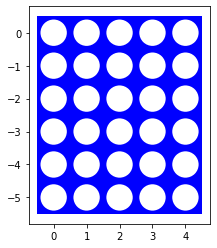

DictType[unicode_type,int64]<iv=None>({value: 0, move: 1})

In [15]:
board = Bitboard(5,6, player_one_mean=False, player_two_mean=False)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search_move_order(board, left_to_right)

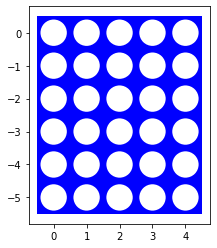

DictType[unicode_type,int64]<iv=None>({value: 0, move: 5})

In [20]:
board = Bitboard(5,6, player_one_mean=False, player_two_mean=False)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search_move_order(board, right_to_left)

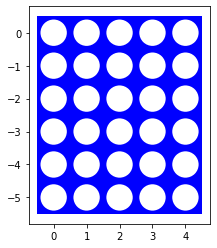

DictType[unicode_type,int64]<iv=None>({value: 0, move: 2})

In [21]:
board = Bitboard(5,6, player_one_mean=False, player_two_mean=False)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search_move_order(board, center_first)

| Move Order      | Time for 5x6 board no mean moves |
| ----------- | ----------- |
| left_to_right      | 8.3s       |
| right_to_left   | 6.9s        |
| center_first   | 5.8s        |


As we can see, the center first is by far the fastest. This makes sense since the center moves are generally the best options. 

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

We will never be able to solve the inital board with minmax with the mean moves turned on. However, we can handicap the first player by not allowing them to use the mean moves which limits the state space. We can also put a depth limit on the search so that we can finish in a set amount of time. I see thats also a requirment for the next section, but I implemented it in this one before reading that haha. I'll talk about it more there

In [16]:
@njit()
def minmax_agent(board, counter):
    action = alpha_beta_search_move_order(board, center_first, counter=counter, depth=5)
    move = action['move']
    
    if move == -1:
        random_move = random_agent(board, counter)
        return random_move
    
    return move

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [17]:
play(minmax_agent, random_agent, 1_000, False, True)

{'red': 1000, 'yellow': 0, 'd': 0}

Woah! Even with a very limited search, we are able to destroy the random agent! This is without our minmax agent even using any mean moves. 

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

For my first heuristic, I add to the score if there is 3 in a row for the player, and subtract from the score if there is 3 in a row for the oponent player.

In [23]:
@njit()
def normal_eval(board, move_num):
    if board.is_bitboard_win(move_num & 1):
        return 1
    
    if board.is_bitboard_win(int(not(move_num & 1))):
        return -1

    if board.is_full():
        return 0

    return None

In [24]:
@njit()
def heuristic_eval(board, move_num):
    normal = normal_eval(board, move_num)
    if normal is not None:
        return normal
    
    if board.is_bitboard_3_in_a_row(move_num & 1):
        return .2

    if board.is_bitboard_3_in_a_row(int(not(move_num & 1))):
        return -.2

    return None

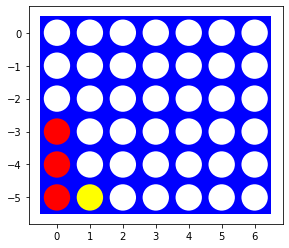

True


In [37]:
# Demo of three in a row code, implemented in the bitboard class so i can use JIT compilation :)
board = Bitboard(7, 6)

board.make_move(0, 1)
board.make_move(1, 2)
board.make_move(0, 1)
board.make_move(0, 1)

visualize(board.bitboards_to_class_board())
print(board.is_bitboard_3_in_a_row(0))

As another heuristic, I decided to implement the history heuristic. I read a really good paper about how it works in chess engines [here](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.589.3958&rep=rep1&type=pdf). It is based on the idea that a specific move may prove to be really good. If thats the case, it would be used as often as possible. I think this will be helpful in our case since the mean moves are probably never very effective.

In [25]:
@njit()
def alpha_beta_search_heuristic(board, eval_func, counter=0, depth=20, use_move_scores=True):
    """start the search."""
    transposition_keys = np.zeros(shape=(TRANSPOSITION_SIZE+1),dtype=np.uint64)
    transposition_vals = np.zeros(shape=(TRANSPOSITION_SIZE+1),dtype=np.int8)
    move_scores = np.zeros(shape=(2, 60), dtype=np.int64)

    value, move = min_max_search_heuristic(board, counter, -1, 1, depth, transposition_keys, transposition_vals, move_scores, eval_func, use_move_scores)

    return { "value": value, "move": move }

@njit()
def min_max_search_heuristic(board, move_num, alpha, beta, depth, transposition_keys, transposition_vals, move_scores, eval_func, use_move_scores):
    # Check for terminal state
    if board.is_full() or depth == 0:
        return 0, -1

    # Check if we have already computed this board
    key = board.get_transposition_key(move_num)
    index = key % TRANSPOSITION_SIZE
    val = transposition_vals[index]

    if transposition_keys[index] == key:
        # We found lowerbound, tighten our search
        alpha = max(alpha, val)

    move = -1

    # Check if any immediate move could lead to terminal state
    for a in board.get_actions(move_num):
        a_board = board.copy()
        a_board.make_move(move_num, a)

        # Add heuristic function
        terminal = eval_func(a_board, move_num)
        if terminal is not None:
            if terminal > alpha:
                alpha = max(alpha, terminal)
                move = a

    if alpha >= beta:
        # Prune!
        return alpha, move
            
    #Depen the search
    actions = np.array(board.get_actions(move_num))
    scores = np.array([move_scores[move_num & 1][action] for action in actions])
    order = scores.argsort()[::-1]

    ordered = actions[order]
    if not use_move_scores:
        ordered = center_first(board, move_num)

    for a in ordered:
        a_board = board.copy()
        a_board.make_move(move_num, a)

        # By calling the same method swapping beta and alpha represents the min move
        # Pretty cool!
        score, _ = min_max_search_heuristic(a_board, move_num + 1, -beta,-alpha, depth-1, transposition_keys, transposition_vals, move_scores, eval_func, use_move_scores)

        # And we can just invert the score at the end
        # This is because the best move for them is the worst move for us
        score = -score

        # Check if we have escaped window
        if score >= beta:
            # We're done, prune the rest
            if use_move_scores:
                move_scores[move_num & 1][a] += 2**depth
            
            return score, a

        # Update alpha always to shrink upperbound
        if score > alpha:
            alpha = score
            move = a
    
    # Update the lower bound for this state
    # We could also update exact and upper bound
    # But seems to be less used
    key = board.get_transposition_key(move_num)
    index = key % TRANSPOSITION_SIZE
    transposition_keys[index] = key
    transposition_vals[index] = alpha

    return alpha, move

### Profiling dynamic move ordering

In [16]:
board = Bitboard(4,6, player_one_mean=False, player_two_mean=True)

alpha_beta_search_heuristic(board, heuristic_eval)

DictType[unicode_type,float64]<iv=None>({value: -0.0, move: 3.0})

In [17]:
board = Bitboard(4,6, player_one_mean=False, player_two_mean=True)

alpha_beta_search_heuristic(board, heuristic_eval, use_move_scores=False)

DictType[unicode_type,float64]<iv=None>({value: 0.0, move: 3.0})

We can see my history heuristic move ordering cut down the search time by about 4 seconds. Not bad!

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [18]:
board = Bitboard(7,6, player_one_mean=False, player_two_mean=False)

In [42]:
alpha_beta_search_heuristic(board, heuristic_eval, depth=10)

DictType[unicode_type,float64]<iv=None>({value: 1.0, move: 4.0})

In [43]:
alpha_beta_search_heuristic(board, heuristic_eval, depth=20)

DictType[unicode_type,float64]<iv=None>({value: 1.0, move: 4.0})

In [44]:
alpha_beta_search_heuristic(board, heuristic_eval, depth=21)

DictType[unicode_type,float64]<iv=None>({value: 1.0, move: 4.0})

All 3 depths returned the same result in a very quick amount of time. Even cooler is that I checked against the solved connect four, and they all returned the optimal move! Very cool!

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

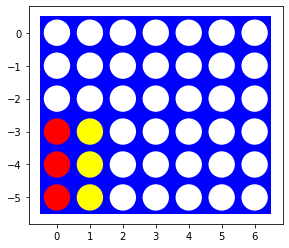

DictType[unicode_type,float64]<iv=None>({value: 1.0, move: 1.0})

In [45]:
board = Bitboard(7, 6)

board.make_move(0, 1)
board.make_move(1, 2)
board.make_move(0, 1)
board.make_move(1, 2)
board.make_move(0, 1)
board.make_move(1, 2)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search_heuristic(board, heuristic_eval)

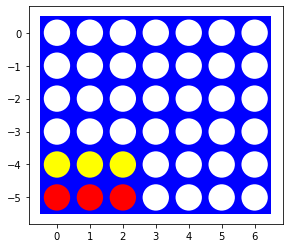

DictType[unicode_type,float64]<iv=None>({value: 1.0, move: 4.0})

In [46]:
board = Bitboard(7, 6)

board.make_move(0, 1)
board.make_move(1, 1)
board.make_move(0, 2)
board.make_move(1, 2)
board.make_move(0, 3)
board.make_move(1, 3)


classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search_heuristic(board, heuristic_eval)

As we can see, it still recognizes the winning moves like above.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

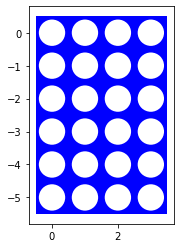

DictType[unicode_type,float64]<iv=None>({value: 0.0, move: 3.0})

In [26]:
board = Bitboard(4,6, player_one_mean=False, player_two_mean=True)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search_heuristic(board, heuristic_eval)

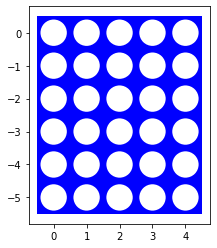

DictType[unicode_type,float64]<iv=None>({value: 0.0, move: 3.0})

In [27]:
board = Bitboard(5,6, player_one_mean=False, player_two_mean=True)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search_heuristic(board, heuristic_eval)

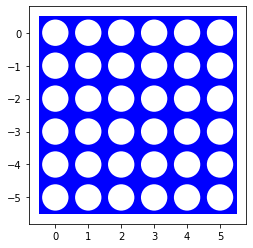

DictType[unicode_type,float64]<iv=None>({value: 0.0, move: 5.0})

In [28]:
board = Bitboard(6,6, player_one_mean=False, player_two_mean=True)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search_heuristic(board, heuristic_eval)

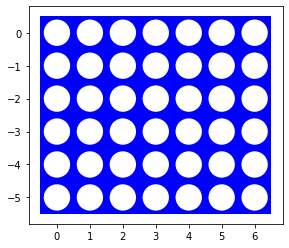

DictType[unicode_type,float64]<iv=None>({value: -0.0, move: 6.0})

In [50]:
board = Bitboard(7,6, player_one_mean=False, player_two_mean=True)

classboard = board.bitboards_to_class_board()
visualize(classboard)

alpha_beta_search_heuristic(board, heuristic_eval)

The heuristic makes the search much faster. While the search is not optimal, we can go as big as the full 7x6 board with a 20 depth cutoff. 

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [29]:
@njit()
def heuristic_eval_agent_1(board, counter):
    action = alpha_beta_search_heuristic(board, heuristic_eval, counter=counter, depth=7)
    move = action['move']
    
    if move == -1:
        random_move = random_agent(board, counter)
        return random_move
    
    return move

In [30]:
@njit()
def heuristic_eval_agent_2(board, counter):
    action = alpha_beta_search_heuristic(board, heuristic_eval, counter=counter, depth=5, use_move_scores=False)
    move = action['move']
    
    if move == -1:
        random_move = random_agent(board, counter)
        return random_move
    
    return np.int64(move)

In [31]:
play(heuristic_eval_agent_1, random_agent, 100, False, True)

{'red': 100, 'yellow': 0, 'd': 0}

In [32]:
play(heuristic_eval_agent_1, random_agent, 100, True, True)

{'red': 95, 'yellow': 5, 'd': 0}

In [33]:
play(heuristic_eval_agent_1, random_agent, 100, True, False)

{'red': 96, 'yellow': 4, 'd': 0}

We can see our heuristic agent can handily beat the random agent even without mean moves turned on. It also beats it with random moves turned on.

In [34]:
play(heuristic_eval_agent_1, heuristic_eval_agent_2, 1, False, True)

{'red': 1, 'yellow': 0, 'd': 0}

In [36]:
play(heuristic_eval_agent_2, heuristic_eval_agent_1, 1, False, True)

{'red': 1, 'yellow': 0, 'd': 0}

Interesting to see that whatever heuristic agent plays first wins against each other. That whos they are pretty similar to each other.

## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [37]:
@njit()
def playout(board, action, counter):
    board.make_move(counter, action)
    counter += 1
    
    while(True):
        if board.is_bitboard_win(0):
            return 1

        if board.is_bitboard_win(1):
            return -1
        
        if board.is_full():
            return 0

        a = np.random.choice(np.array(board.get_actions(counter)))
        board.make_move(counter, a)
        counter += 1

In [38]:
@njit(parallel=False)
def playouts(board, action, counter = 0, N = 10_000):
    """Perform N playouts following the given action for the given board."""
    return np.array([ playout(board.copy(), action, counter) for i in range(N) ])

board = Bitboard(6, 7)
u = playouts(board,5)
#print("Playout results:", u)

print(f"mean utility: {np.mean(u)}")

p_win = sum(np.array(u) == +1)/len(u)
p_loss = sum(np.array(u) == -1)/len(u)
p_draw = sum(np.array(u) == 0)/len(u)
print(f"win probability: {p_win}")
print(f"loss probability: {p_loss}")
print(f"draw probability: {p_draw}")

mean utility: 0.551
win probability: 0.7755
loss probability: 0.2245
draw probability: 0.0


In [39]:
import math
from numba import prange

@njit(parallel=False)
def pmcs(board, counter, N = 100, debug=False):
    actions = board.get_actions(counter)

    n = math.floor(N/len(actions))

    player = counter & 1

    score_mod = 1.0 if player == 0 else -1.0

    max_score = -1000.0
    max_move = actions[0]

    for move in actions:
        plays = playouts(board, move, counter, N = n)

        score = score_mod*np.mean(plays)

        if score > max_score:
            max_score = score
            max_move = move

    return max_move

@njit()
def pmcs_agent(board, counter):
    action = pmcs(board, counter, N=10_000)
    return action

In [40]:
play(pmcs_agent, random_agent, N = 10)

{'red': 10, 'yellow': 0, 'd': 0}

In [42]:
play(random_agent, pmcs_agent, N = 20)

{'red': 0, 'yellow': 20, 'd': 0}

### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [43]:
board = Bitboard(7, 6)
u = pmcs(board, 0, 1_000_000)

print("The best column is: ", u)

The best column is:  7


According to the above, the last column is the best option when mean moves are turned on for both players.

In [45]:
board = Bitboard(7, 6, player_one_mean=False, player_two_mean=False)
u = pmcs(board, 0, 1_000_000)

print("The best column is: ", u)

The best column is:  4


The above is just for normal connect four, and it (correctly) predicts that the middle column is the best move.

# Troy's Algorithm

In [46]:
@njit()
def playout_troy(board, action, counter):
    board.make_move(counter, action)
    counter += 1
    
    while(True):
        if board.is_bitboard_win(0):
            return 1

        if board.is_bitboard_win(1):
            return -1
        
        if board.is_full():
            return 0

        actions = np.array(board.get_actions(counter))
        if np.random.rand() < 0.7:
            actions = actions[actions < 10]

        a = np.random.choice(actions)
        board.make_move(counter, a)
        counter += 1

@njit()
def playouts_troy(board, action, counter = 0, N = 10_000):
    """Perform N playouts following the given action for the given board."""
    return np.array([ playout_troy(board.copy(), action, counter) for i in range(N) ])

@njit()
def pmcs_troy(board, counter, N = 100):
    actions = board.get_actions(counter)

    n = math.floor(N/len(actions))

    player = counter & 1

    score_mod = 1.0 if player == 0 else -1.0

    max_score = -1000.0
    max_move = 0

    for move in actions:
        plays = playouts_troy(board, move, counter, N = n)

        score = score_mod*np.mean(plays)

        if score > max_score:
            max_score = score
            max_move = move

    return max_score, max_move

@njit()
def alpha_beta_troy(board, counter=0, depth=1):
    """start the search."""
    transposition_keys = np.zeros(shape=(TRANSPOSITION_SIZE+1),dtype=np.uint64)
    transposition_vals = np.zeros(shape=(TRANSPOSITION_SIZE+1),dtype=np.int8)

    mc_keys = np.zeros(shape=(TRANSPOSITION_SIZE+1),dtype=np.uint64)
    mc_vals = np.zeros(shape=(TRANSPOSITION_SIZE+1),dtype=np.int8)

    value, move = min_max_search_troy(board, counter, -2, 1, depth, transposition_keys, transposition_vals, mc_keys, mc_vals)

    return { "value": value, "move": move }

@njit()
def min_max_search_troy(board, move_num, alpha, beta, depth, transposition_keys, transposition_vals, mc_keys, mc_vals):
    # Check for terminal state
    if board.is_full():
        return 0, -1

    # Check if we have already computed this board
    key = board.get_transposition_key(move_num)
    index = key % TRANSPOSITION_SIZE

    if depth == 0:
        if mc_keys[index] == key:
            return mc_vals[index], -1
        
        # We ran out of room, swap to pmcs
        max_mc_score, max_mc_move = pmcs_troy(board, move_num, N=100)
        mc_vals[index] = max_mc_score
        mc_keys[index] = key
        
        return max_mc_score, max_mc_move

   
    val = transposition_vals[index]

    if transposition_keys[index] == key:
        # We found lowerbound, tighten our search
        alpha = max(alpha, val)
      
    #Deepen the search
    move = -1

    # Check if any immediate move could lead to terminal state
    for a in center_first(board, move_num):
        a_board = board.copy()
        a_board.make_move(move_num, a)

        #if a_board.is_bitboard_win(move_num & 1):
        #    return 1, a

        #if a_board.is_bitboard_win(int(not(move_num & 1))):
        #    return -1, a

        # Add heuristic function
        terminal = heuristic_eval(a_board, move_num)
        if terminal is not None:
            if terminal > alpha:
                alpha = max(alpha, terminal)
                move = a

    if alpha >= beta:
        # Prune!
        return alpha, move

    #Depen the search
    for a in center_first(board, move_num):
        a_board = board.copy()
        a_board.make_move(move_num, a)

        # By calling the same method swapping beta and alpha represents the min move
        # Pretty cool!
        score, _ = min_max_search_troy(a_board, move_num + 1, -beta,-alpha, depth-1, transposition_keys, transposition_vals, mc_keys, mc_vals)

        # And we can just invert the score at the end
        # This is because the best move for them is the worst move for us
        score = -score

        # Check if we have escaped window
        if score >= beta:
            # We're done, prune the rest
            return score, a

        # Update alpha always to shrink upperbound
        if score > alpha: 
            alpha = score
            move = a
    
    # Update the lower bound for this state
    # We could also update exact and upper bound
    # But seems to be less used
    key = board.get_transposition_key(move_num)
    index = key % TRANSPOSITION_SIZE
    transposition_keys[index] = key
    transposition_vals[index] = alpha

    return alpha, move

def troy_agent(board, counter):
    action = alpha_beta_troy(board, counter=counter, depth=4)
    move = action['move']
    
    assert move != -1
    return move

### Me vs Random

In [47]:
play(troy_agent, random_agent, N = 50)

{'red': 50, 'yellow': 0, 'd': 0}

In [48]:
play(random_agent, troy_agent, N = 50)

{'red': 0, 'yellow': 50, 'd': 0}

## Me vs minmax agent

In [86]:
play(troy_agent, minmax_agent, N = 50)

{'red': 46, 'yellow': 4, 'd': 0}

## Me vs heuristic - 1

In [49]:
play(troy_agent, heuristic_eval_agent_1, N = 50)

{'red': 31, 'yellow': 19, 'd': 0}

In [50]:
play(heuristic_eval_agent_1, troy_agent, N = 50)

{'red': 0, 'yellow': 50, 'd': 0}

## Me vs heuristic - 2

In [51]:
play(troy_agent, heuristic_eval_agent_2, N = 50)

{'red': 50, 'yellow': 0, 'd': 0}

In [52]:
play(heuristic_eval_agent_2, troy_agent, N = 50)

{'red': 32, 'yellow': 18, 'd': 0}

## Me vs monte carlo

In [53]:
play(troy_agent, pmcs_agent, N = 50)

{'red': 49, 'yellow': 1, 'd': 0}

In [54]:
play(pmcs_agent, troy_agent, N = 50)

{'red': 13, 'yellow': 37, 'd': 0}

Not too bad!